In [18]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [20]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [21]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить.  
Посмотрим на распределение классов:

In [22]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [23]:
df = df.drop(['Surname', 'CustomerId','RowNumber','Geography'], axis = 1).copy()

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Gender           10000 non-null  object 
 2   Age              10000 non-null  int64  
 3   Tenure           10000 non-null  int64  
 4   Balance          10000 non-null  float64
 5   NumOfProducts    10000 non-null  int64  
 6   HasCrCard        10000 non-null  int64  
 7   IsActiveMember   10000 non-null  int64  
 8   EstimatedSalary  10000 non-null  float64
 9   Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 781.4+ KB


In [25]:
df.describe(include='object')

,Gender
count,10000
unique,2
top,Male
freq,5457


In [26]:
k = 0
for i in df['Gender'].unique():
    df.loc[df.Gender == i, 'Gender'] = k
    k = k + 1
df['Gender']= pd.to_numeric(df.Gender, errors='coerce')

In [27]:
categorical_columns = ['Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Буду строить модель с использованием sklearn pipeline

In [28]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

Категориальные признаки закодируем с помощью OneHotEncoding  
Вещественные оставим пока как есть

In [29]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.column]
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transfo
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[[self.key]]
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []
    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self
    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
gender = Pipeline([
    ('selector', FeatureSelector(column='Gender')),
    ('ohe', OHEEncoder(key='Gender'))
    ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_0,Gender_1
9394,1,0
898,1,0
2398,1,0


Теперь под каждый признак создам трансформер и объединю их в список (чтобы не мучиться)

In [31]:
final_transformers = list()
for cat_col in categorical_columns:
    cat_transformer = Pipeline([
        ('selector', FeatureSelector(column=cat_col)),
        ('ohe', OHEEncoder(key=cat_col))
        ])
    final_transformers.append((cat_col, cat_transformer))
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
        ('selector', NumberSelector(key=cont_col))
        ])
    final_transformers.append((cont_col, cont_transformer))

In [32]:
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,42,2,0.00,1,1,1,101348.88,1
1,608,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,39,1,0.00,2,0,0,93826.63,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0


Объединю все это в единый пайплайн

In [33]:
feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

In [34]:
from sklearn.linear_model import LogisticRegression

In [36]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression()),
    ])

In [37]:
#обучаю пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenure')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Tenure'))])),
                                                ('HasCrCard',
                                                 Pipeline(steps=[('selector',
                 

In [38]:
#прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22377741, 0.33721268, 0.18491789, 0.09209211, 0.18581757,
       0.40868456, 0.18824887, 0.18373706, 0.43529975, 0.70861594])

In [55]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report,precision_recall_curve, confusion_matrix

In [43]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
        fscore[ix],
        precision[ix],
        recall[ix]))

Best Threshold=0.750136, F-Score=nan, Precision=0.000, Recall=0.000


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [44]:
from sklearn.ensemble import GradientBoostingClassifier

In [45]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
            max_depth=8, random_state=0).fit(X_train, y_train)

In [46]:
pipeline = Pipeline([
        ('features',feats),
        ('classifier', gbc),
        ])

In [49]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenure')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Tenure'))])),
                                                ('HasCrCard',
                                                 Pipeline(steps=[('selector',
                 

In [50]:
#прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([5.86735397e-04, 6.29074320e-02, 4.06402954e-05, 6.36010357e-05,
       9.40516068e-04, 8.78544860e-01, 7.93783871e-08, 9.05116373e-04,
       1.39980949e-04, 9.99999056e-01])

In [51]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                                        fscore[ix],
                                                                                        precision[ix],
                                                                                        recall[ix]))

Best Threshold=0.127092, F-Score=0.558, Precision=0.535, Recall=0.583


матрица ошибок

In [52]:
def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1733  258]
 [ 213  296]]


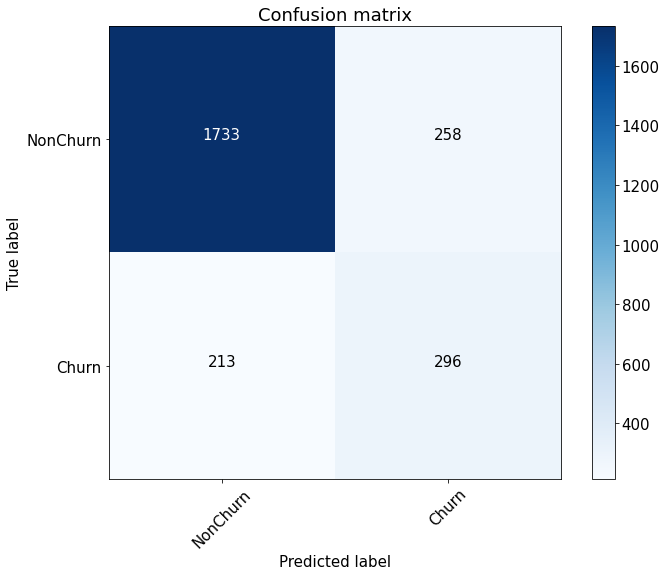

In [56]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                                        title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()